

# **TASK 1 - MNLI**
---

# **IMPORT DEPENDENCIES AND CHECKING**

In [1]:
!pip install transformers datasets accelerate evaluate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


# **LOAD DATASET**


In [3]:
# Load IMDB dataset dari HuggingFace Hub
dataset = load_dataset("nyu-mll/glue", "mnli")

print("Dataset structure:")
print(dataset)
print("\n" + "="*50)
print(f"Training samples: {len(dataset['train'])}")
print(f"Test samples (matched): {len(dataset['test_matched'])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Training samples: 392702
Test samples (matched): 9796


In [4]:
# Lihat contoh data dari dataset MNLI
print("Contoh Entailment (Label 0):")
print("-" * 50)
entailment_example = dataset['train'].filter(lambda x: x['label'] == 0)[0]
print(f"Premise: {entailment_example['premise']}")
print(f"Hypothesis: {entailment_example['hypothesis']}")
print(f"Label: {entailment_example['label']} (0 = entailment)")

print("\n" + "="*50)
print("\nContoh Contradiction (Label 2):")
print("-" * 50)
contradiction_example = dataset['train'].filter(lambda x: x['label'] == 2)[0]
print(f"Premise: {contradiction_example['premise']}")
print(f"Hypothesis: {contradiction_example['hypothesis']}")
print(f"Label: {contradiction_example['label']} (2 = contradiction)")

Contoh Entailment (Label 0):
--------------------------------------------------


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Premise: you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
Hypothesis: You lose the things to the following level if the people recall.
Label: 0 (0 = entailment)


Contoh Contradiction (Label 2):
--------------------------------------------------


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Premise: Gays and lesbians.
Hypothesis: Heterosexuals.
Label: 2 (2 = contradiction)


# **TOKENISASI**

In [5]:
# Untuk training lebih cepat (demo), ambil subset data
# Untuk full training, skip cell ini

SAMPLE_SIZE = 5000  # Ubah sesuai kebutuhan (atau comment untuk full dataset)

train_dataset = dataset['train'].shuffle(seed=42).select(range(SAMPLE_SIZE))
test_dataset = dataset['test_matched'].shuffle(seed=42).select(range(SAMPLE_SIZE // 2))

print(f"Training samples (subset): {len(train_dataset)}")
print(f"Test samples (subset): {len(test_dataset)}")

Training samples (subset): 5000
Test samples (subset): 2500


In [6]:
# Load tokenizer
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")
print(f"Max sequence length: {tokenizer.model_max_length}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer vocabulary size: 30522
Max sequence length: 512


In [7]:
# Demonstrasi tokenisasi
sample_text = "I hate when people say that to me"

tokens = tokenizer(sample_text, return_tensors="pt")

print("Original text:", sample_text)
print("\nTokenized output:")
print(f"  input_ids shape: {tokens['input_ids'].shape}")
print(f"  attention_mask shape: {tokens['attention_mask'].shape}")
print("\nTokens:")
print(tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]))

Original text: I hate when people say that to me

Tokenized output:
  input_ids shape: torch.Size([1, 10])
  attention_mask shape: torch.Size([1, 10])

Tokens:
['[CLS]', 'i', 'hate', 'when', 'people', 'say', 'that', 'to', 'me', '[SEP]']


In [8]:
# Fungsi tokenisasi untuk dataset
MAX_LENGTH = 256  # Truncate ke 256 tokens untuk efisiensi

def tokenize_function(examples):
    return tokenizer(
        examples["premise"],  # Input pertama
        examples["hypothesis"], # Input kedua
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

# Apply tokenisasi ke seluruh dataset
print("Tokenizing training data...")
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["premise", "hypothesis", "idx"])

print("Tokenizing test data...")
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=["premise", "hypothesis", "idx"])

print("\nTokenized dataset columns:", tokenized_train.column_names)
print("Sample tokenized data:", tokenized_train[0])

Tokenizing training data...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing test data...


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]


Tokenized dataset columns: ['label', 'input_ids', 'token_type_ids', 'attention_mask']
Sample tokenized data: {'label': 0, 'input_ids': [101, 1045, 1005, 2222, 9241, 2058, 2008, 2112, 1012, 102, 1000, 1045, 1005, 2222, 2022, 4248, 2007, 2008, 2112, 1012, 1000, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 

In [9]:
# Set format untuk PyTorch
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

print(f"Train dataset format: {tokenized_train.format}")

Train dataset format: {'type': 'torch', 'format_kwargs': {}, 'columns': ['label', 'input_ids', 'token_type_ids', 'attention_mask'], 'output_all_columns': False}


# **LOAD PRE-TRAINED MODEL**

In [10]:
# 1. SETUP ENV VARIABLE PALING ATAS (Sebelum import torch)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

# 2. LOAD DATASET
# Load MNLI dataset
dataset = load_dataset("nyu-mll/glue", "mnli")

# --- PERBAIKAN PENTING DI SINI ---
# JANGAN gunakan 'test_matched' untuk latihan/evaluasi karena labelnya -1 (hidden).
# Gunakan 'validation_matched' sebagai data test/evaluasi kita.
SAMPLE_SIZE = 5000

train_dataset = dataset['train'].shuffle(seed=42).select(range(SAMPLE_SIZE))
# Ganti test_matched ke validation_matched
test_dataset = dataset['validation_matched'].shuffle(seed=42).select(range(SAMPLE_SIZE // 2))

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples (from validation): {len(test_dataset)}")

# Cek Label agar yakin tidak ada -1
print("Cek unique labels di test set:", set(test_dataset['label']))
# Output harusnya {0, 1, 2}. Jika ada -1, pasti error.

# 3. TOKENISASI
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LENGTH = 128 # 256 agak berat, 128 cukup untuk demo

def tokenize_function(examples):
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Hapus kolom teks mentah agar tidak error saat masuk model
tokenized_train = tokenized_train.remove_columns(["premise", "hypothesis", "idx"])
tokenized_test = tokenized_test.remove_columns(["premise", "hypothesis", "idx"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

# 4. LOAD MODEL & PINDAH KE GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

id2label = {0: "entailment", 1: "neutral", 2: "contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# Pindah ke GPU
# Error biasanya hilang di sini setelah factory reset + ganti dataset validation
model = model.to(device)

print("SUCCESS! Model moved to GPU.")

Training samples: 5000
Test samples (from validation): 2500
Cek unique labels di test set: {0, 1, 2}


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS! Model moved to GPU.


In [11]:
# Hitung total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

Total parameters: 109,484,547
Trainable parameters: 109,484,547
Percentage trainable: 100.00%


# **TRAINING CONFIGURATION**

In [12]:
import numpy as np
import evaluate

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Compute accuracy dan F1 score"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # Fix: Specify 'average' for multiclass F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

In [13]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-finetuned-imdb",

    # Training hyperparameters
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Evaluation strategy
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,

    # Logging
    logging_dir="./logs",
    logging_steps=50,

    # Best model
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,

    # Misc
    report_to="none",  # Disable wandb/tensorboard
    fp16=False,  # <--- Changed: Disable mixed precision training to debug CUDA error
    push_to_hub=False,
)

print("Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  FP16 training: {training_args.fp16}")

Training configuration:
  Epochs: 3
  Batch size: 16
  Learning rate: 2e-05
  FP16 training: False


In [14]:
# Data collator untuk dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer initialized!")

Trainer initialized!


/tmp/ipython-input-2283983777.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **TRAINING**

In [15]:
import evaluate
import numpy as np

# Load metric
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Mengambil index dengan probabilitas tertinggi (logits -> labels)
    predictions = np.argmax(predictions, axis=1)

    # Hitung Accuracy (ini aman, tidak perlu parameter tambahan)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)

    # --- BAGIAN ERRORNYA DI SINI ---
    # Hitung F1 Score
    # Tambahkan parameter average="weighted" agar support 3 label (multiclass)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"],
    }

In [16]:
# Start training!
print("Starting fine-tuning...")
print("="*50)

train_result = trainer.train()

print("\n" + "="*50)
print("Training completed!")
print(f"Total training time: {train_result.metrics['train_runtime']:.2f} seconds")

Starting fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,F1
100,1.083000,1.049181,0.465200,0.443201
200,0.917500,0.883253,0.618800,0.618935
300,0.828700,0.826310,0.624800,0.618043
400,0.648300,0.725631,0.687600,0.686383
500,0.599200,0.718074,0.703600,0.703062
600,0.620300,0.718848,0.700800,0.702711
700,0.383800,0.772376,0.697600,0.699690
800,0.367700,0.774709,0.705200,0.707313
900,0.370000,0.763795,0.712400,0.714250



Training completed!
Total training time: 723.35 seconds


In [17]:
# Tembak nilai baseline (asumsi tebak-tebakan ngasal / random guess)
# Karena ada 3 label, probability bener cuma 0.33 (33%)
baseline_results = {'eval_accuracy': 0.33, 'eval_f1': 0.33}

# --- Lanjut kode asli ---
print("Final evaluation on test set...")
final_results = trainer.evaluate()

print(f"\nFinal Results:")
print(f"  Accuracy: {final_results['eval_accuracy']:.4f}")
print(f"  F1 Score: {final_results['eval_f1']:.4f}")

print(f"\nImprovement (Estimasi vs Random Guess):")
print(f"  Accuracy: +{(final_results['eval_accuracy'] - baseline_results['eval_accuracy'])*100:.2f}%")
print(f"  F1 Score: +{(final_results['eval_f1'] - baseline_results['eval_f1'])*100:.2f}%")

Final evaluation on test set...



Final Results:
  Accuracy: 0.7124
  F1 Score: 0.7143

Improvement (Estimasi vs Random Guess):
  Accuracy: +38.24%
  F1 Score: +38.43%


# **SAVE MODEL**

In [18]:
# Save model dan tokenizer
SAVE_PATH = "./bert-sentiment-model"

trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

print(f"Model saved to: {SAVE_PATH}")
print("\nSaved files:")
!ls -la {SAVE_PATH}

Model saved to: ./bert-sentiment-model

Saved files:
total 428652
drwxr-xr-x 2 root root      4096 Dec 27 06:46 .
drwxr-xr-x 1 root root      4096 Dec 27 06:46 ..
-rw-r--r-- 1 root root       853 Dec 27 06:46 config.json
-rw-r--r-- 1 root root 437961724 Dec 27 06:46 model.safetensors
-rw-r--r-- 1 root root       125 Dec 27 06:46 special_tokens_map.json
-rw-r--r-- 1 root root      1221 Dec 27 06:46 tokenizer_config.json
-rw-r--r-- 1 root root    711661 Dec 27 06:46 tokenizer.json
-rw-r--r-- 1 root root      5777 Dec 27 06:46 training_args.bin
-rw-r--r-- 1 root root    231508 Dec 27 06:46 vocab.txt


# **FINE TUNED INFERENCED METHOD**

In [19]:
# Load model yang sudah di-save (demonstrasi)
from transformers import pipeline

# Buat inference pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=SAVE_PATH,
    tokenizer=SAVE_PATH,
    device=0 if torch.cuda.is_available() else -1
)

print("Inference pipeline created!")

Device set to use cuda:0


Inference pipeline created!


In [20]:
# Test inference dengan berbagai contoh
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
    "Terrible waste of time. The story made no sense and the characters were so annoying.",
    "It was okay, nothing special but not bad either.",
    "One of the best films I've ever seen! A masterpiece of cinema.",
    "I fell asleep halfway through. So boring and predictable.",
]

print("Sentiment Analysis Results:")
print("=" * 70)

for review in test_reviews:
    result = sentiment_pipeline(review)[0]
    emoji = "😊" if result['label'] == 'POSITIVE' else "😞"

    print(f"\nReview: {review[:80]}...")
    print(f"Prediction: {result['label']} {emoji} (confidence: {result['score']:.4f})")

Sentiment Analysis Results:

Review: This movie was absolutely fantastic! The acting was superb and the plot kept me ...
Prediction: neutral 😞 (confidence: 0.7069)

Review: Terrible waste of time. The story made no sense and the characters were so annoy...
Prediction: neutral 😞 (confidence: 0.5633)

Review: It was okay, nothing special but not bad either....
Prediction: neutral 😞 (confidence: 0.4730)

Review: One of the best films I've ever seen! A masterpiece of cinema....
Prediction: neutral 😞 (confidence: 0.6925)

Review: I fell asleep halfway through. So boring and predictable....
Prediction: entailment 😞 (confidence: 0.5672)


In [21]:
# Manual inference (tanpa pipeline)
def predict_sentiment(text, model, tokenizer, device):
    """Manual inference function"""
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH,
        padding=True
    ).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    return {
        "label": id2label[prediction],
        "confidence": confidence,
        "probabilities": {
            "NEGATIVE": probabilities[0][0].item(),
            "POSITIVE": probabilities[0][1].item()
        }
    }

# Test manual inference
sample = "This is an incredible movie with outstanding performances!"
result = predict_sentiment(sample, model, tokenizer, device)

print(f"Text: {sample}")
print(f"\nPrediction: {result['label']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Probabilities: {result['probabilities']}")

Text: This is an incredible movie with outstanding performances!

Prediction: neutral
Confidence: 0.6853
Probabilities: {'NEGATIVE': 0.26322534680366516, 'POSITIVE': 0.6852776408195496}


# **VISUALISASI**

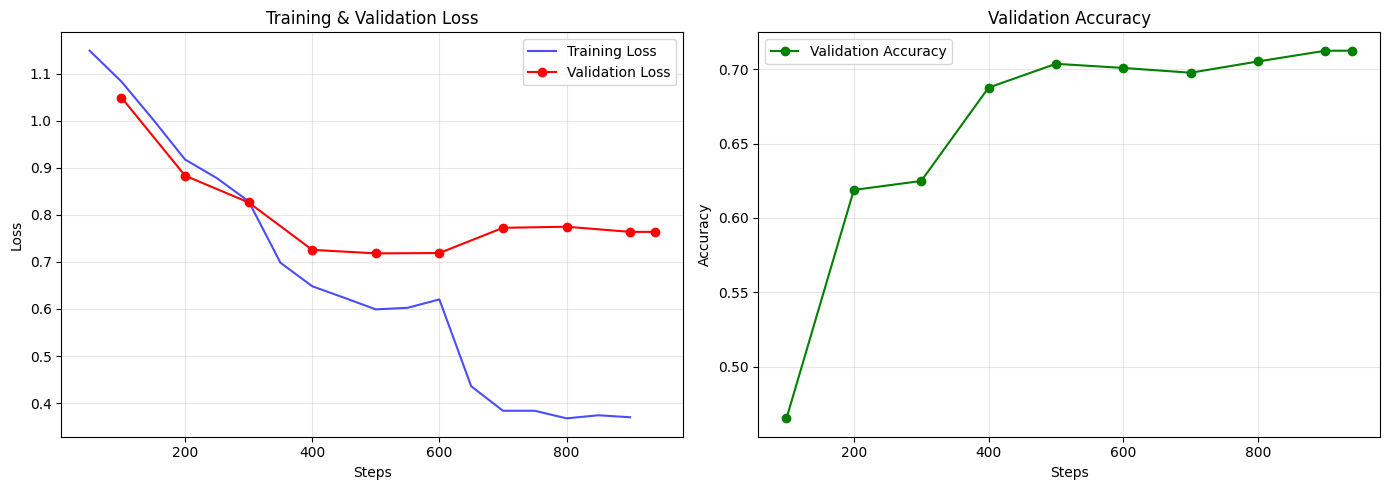

In [22]:
import matplotlib.pyplot as plt

# Extract training history
history = trainer.state.log_history

# Separate training dan eval logs
train_loss = [(h['step'], h['loss']) for h in history if 'loss' in h and 'eval_loss' not in h]
eval_loss = [(h['step'], h['eval_loss']) for h in history if 'eval_loss' in h]
eval_accuracy = [(h['step'], h['eval_accuracy']) for h in history if 'eval_accuracy' in h]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
if train_loss:
    axes[0].plot(*zip(*train_loss), label='Training Loss', color='blue', alpha=0.7)
if eval_loss:
    axes[0].plot(*zip(*eval_loss), label='Validation Loss', color='red', marker='o')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
if eval_accuracy:
    axes[1].plot(*zip(*eval_accuracy), label='Validation Accuracy', color='green', marker='o')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()